# Annihilation Strain Function and Plot

In [2]:
import numpy as np
import mpmath as mp
# Requires omega in Hz, M in solar masses, alpha = dimensionless, r in kpc
# r is distance from us to binary

# H_ann gives the change in frequency from \omega_ann. Centered in the MHz, but with \delta f being extremely small.

Mp = 1.220890e19
G = 1 / Mp**2   
def h_ann(omega, M,n,l,alpha, r):

    # Define called on functions

    def omega_ann(mua, alpha, n):
        return 2 * mua * (1 - alpha**2 / (2 * n**2))

    def gamma_a(l, alpha, M):
        if l == 1:
            p = 17
        else:
            p = 4 * l + 1
        rg = G * M
        return G * 1e-10 / rg**3 * (((alpha / l) * 0.5)**p + ((alpha / l) * 0.5)**(p + 1))

    def _mp_ei_vec(z):
        return np.vectorize(lambda zz: complex(mp.ei(zz)))(z)

    # Define Conversions and Constants
    Mp = 1.220890e19
    G = 1 / Mp**2
    M_sun = 2e30 * 5.61e26 # Solar mass - > Gev
    Mpc_to_Gev = 1.56e38        # 1 Mpc in GeV
    kpc_to_Gev = Mpc_to_Gev / 1000
    Hz_to_Gev = 4.1357e-24 # Hz - > Gev
    hbar_GeV = 6.582e-25 
    # Convert to natural units

    M_ann = M*M_sun # Solar mass -> GeV
    mua = alpha/(G*M_ann) # Mu in GeV
    r_kpc = r * kpc_to_Gev # Kpc - > GeV
    print(f'Mua: {mua}')
    print(f'M: {M_ann}')



    omega_a = omega_ann(mua, alpha, n) 
    Gamma = gamma_a(l,alpha,M_ann)

    # Approximate maximum population of states
    N_max = 10**(76)*(M/10)**2
    omega = np.asarray(np.multiply(omega,Hz_to_Gev))
    print(f'Omega (Gev): {np.abs(min(omega))}')
    z = 1j * omega / (Gamma * N_max)  # argument for Ei and exponential
    
    pref = 1/(2*np.pi)*np.sqrt(4.0 * G  / (Gamma*r_kpc**2 * omega_a))
    Ei = -2.0 * _mp_ei_vec(z) - np.log(-1j*omega) + np.log(1j*omega) + 1j * np.pi * np.sign(np.real(omega)) 
    freq = omega/ (2*np.pi*Hz_to_Gev)
    print(f'Freq: {freq}')
    # frequency strain has units of h*Gev, need to convert to Hz and then divide by timescale of event (2e6) to match discrete fft
    return pref * np.exp(z) *Ei*hbar_GeV, freq

In [4]:
mp.ei(1+2j)

mpc(real='1.0421677081649356', imag='3.7015014259378742')

Mua: 2.0000000000000002e-16
M: 3.4782e+53
Omega (Gev): 4.1357e-37
Freq: [1.59154943e-14 1.59338301e-14 1.59521870e-14 ... 1.58788860e-09
 1.58971796e-09 1.59154943e-09]


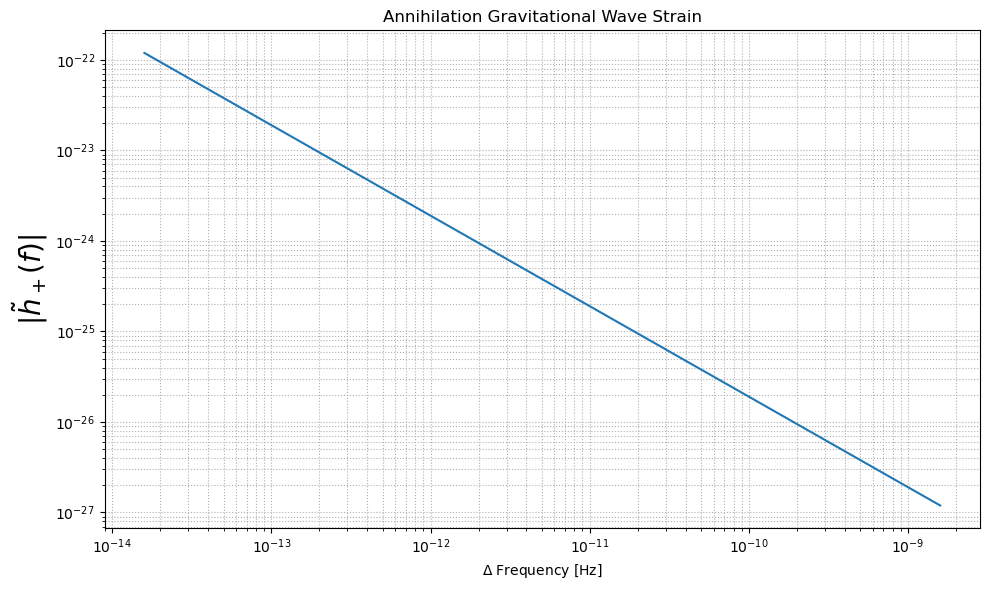

In [2]:
from matplotlib import pyplot as plt

# Plot label params
title_fs = 20
label_fs = 20
tick_fs  = 20
legend_fs = 15


# Relevant conversions
M_sun = 2e30 * 5.61e26 # Solar mass - > Gev

# Dependent Params
M_ann = 3.1e-04  # in solar masses
mua_ann = 2e-16  # in GeV
alpha_ann = G*M_ann*mua_ann*M_sun
r_kpc = 1
n = 4
m = l = n-1

# call functions
omega = np.logspace(-13, -8, 10000) # in Hz

ann_strain_abs,frequency = np.abs(h_ann(omega, M_ann,n,l,alpha_ann, r_kpc))



plt.figure(figsize=(10, 6))
plt.title('Annihilation Gravitational Wave Strain')
plt.plot(frequency, ann_strain_abs)
plt.xlabel('$\Delta$ Frequency [Hz]')
plt.ylabel(r"$|\tilde h_+(f)|$", fontsize=label_fs)
plt.xscale('log')
plt.yscale('log')    
# plt.xlim(1, 1e4)
# plt.ylim(1e-45, 1e-42)
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

# Binary Merger Template and Plot
check this code with Henry

In [3]:
import numpy as np
import math

def htilde_plus(
    f,                     # array-like (Hz in your chosen units)
    Msun, r, alpha,           # source mass (Solar mass), distance (kpc), fine-structure parameter,  
    q,                     # binary mass ratio (companion/host)
    m_i, m_f,              # initial/final magnetic quantum numbers (e.g., 1 -> -1)
    eta,                   # parameter entering z (or leave None to use z_scaling below,            
    use_z_scaling=False,    # if True, use Eq. (15.5) instead of z=η^2/(|Δm|γ)
    relativistic = False
):

    # Horizon Angular velocity funct, takes spin param a^* and r_plus spin horizon radius. Units are in inverse GeV
    def Omega_plus(a, r):
        return a / (2 * r)

    # Omega needs to be in units of GeV. Since mass is only thing dimensionfull, 
    # need to add a factor of G into denominator ( [1/(M*G)] = GeV )
    def Omega0_hyp(M, m_i, alpha, n, l):

        numerator = 64 * m_i * alpha**7
        denominator = G*M * n**3 * (2**l) * (2*l + 1) * (2*l + 2) * (m_i**2 + 4 * alpha**2)
        return numerator / denominator


    # Kerr spin horizon radius, takes Mass in Gev, and dimensionless spin
    def r_plus(M, a):
        return M * (1 + np.sqrt(1 - a**2)) * G
    
    # Superradiant rate in 
    def super_gamma(n, l, m, omega, mu, M, r, a):

        def glm(a, m, l, r, omega):
            g = 1
            if l == 1:
                g *= l**2 * (1 - a**2) + (a * m - 2 * r * omega)**2
            if l != 1:
                for k in range(1, l):
                    g *= k**2 * (1 - a**2) + (a * m - 2 * r * omega)**2
            return g

        C = (
            2**(4 * l - 1)
            * math.factorial(n + l)
            / (n**(2 * l + 4) * math.factorial(n - l - 1))
            * (math.factorial(l) / (math.factorial(2 * l) * math.factorial(2 * l + 1)))**2
        )
        g = glm(a, m, l, r, omega)
        omega_plus = Omega_plus(a, r)
        gamma_nlm = (
            2 * r / M * C * g * (m * omega_plus - omega) * (G * mu * M)**(4 * l + 5) / G 
        )
        return gamma_nlm

    # takes dimensionless quantum number m_i and alpha
    def a_tilde_crit(m_i, alpha):
        m2 = m_i**2
        return (4.0 * m_i * alpha) / (m2 + 4.0 * alpha**2)

    # all dimensionless
    def q_c(alpha, m_i, a_tilde):

        m = float(m_i)
        one_minus = (1.0 - a_tilde / m)
        # guard small rounding errors inside the sqrt:
        inner = 1.0 - (4.0 * alpha / m * one_minus) ** 2
        inner = np.clip(inner, 0.0, 1.0)

        denom = m**2 * (1.0 - np.sqrt(inner))**2
        # Avoid divide-by-zero:
        if denom == 0.0:
            return 0.0

        return 8.0 * alpha**2 * one_minus / denom


    # M is host BH mass


    # takes mass in Gev, dimensionless q_c, r in GeV is distance from Earth, Omega_0 is angular momentum at BH horizon in GeV
    def h0_from_params(qc, M, r, alpha, Omega0):

        return 24.0 * G*(qc * M / r) * (alpha ** -4) * (G*M * Omega0) ** 2

    def gamma_rate(q, M, Omega0):
        return (Omega0**2) * (96.0 / 5.0) * (q / (q + 1.0) ** (1.0 / 3.0)) * (M * Omega0) ** (5.0 / 3.0)


    def z_parameter(eta, Delta_m, gamma):
        return (eta ** 2) / (abs(Delta_m) * gamma)

    def z_scaling_211_to_21m1(alpha, q):
        """
        z_{211->21-1} ≈ 7 * (1.81/(1+4 α^2))^(1/3) * (q)^(1/3) * (2/(1+q))^(5/3) * (0.45/α)^(11/3)
        """
        return 7.0 * (1.81 / (1.0 + 4.0 * alpha**2)) ** (1.0 / 3.0) \
                * (q ** (1.0 / 3.0)) \
                * (2.0 / (1.0 + q)) ** (5.0 / 3.0) \
                * (0.45 / alpha) ** (11.0 / 3.0)

    def fc_from_Omega0(Omega0):
        return (2.0 / np.pi) * Omega0*1e23

    def psi_plus(f, r, f0, Delta_m, gamma):
        return f * r + (f - f0) ** 2 / (4.0 * abs(Delta_m) * gamma) - np.pi / 4.0

    # New Function used in the adjusted amplitude from Henrys paper
    def g(z):
        z = np.asarray(z, dtype=np.complex128)
        num = np.exp(-np.pi*z + 2*z*np.arctan(2*z))
        den = np.sqrt(1 + 4*z**2)
        
        return num / den


    # Relavant constants/ conversions
    Mp = 1.220890e19
    G = 1 / Mp**2   
    M_sun = 2e30 * 5.61e26 # Solar mass - > Gev
    r *=  1.6e35 # Kpc -> GeV^-1
    # Convert to natural units
    M = Msun*M_sun # Solar mass - > GeV
    m_boson = alpha/(G*M) # Boson mass in GeV

    a = a_tilde_crit(m_i, alpha)
    Omega0 = Omega_plus(a,r_plus(M,a)) / (2.0/np.pi) 
    Omega_binary = Omega0_hyp(M, m_i, alpha, 2, 1)

    print(f'Omega Binary: {Omega_binary}')
    print(f'Omega BH: {Omega0}')
    
    # gamma takes BH rotational freq
    if relativistic == False:
        Gamma_abs = super_gamma(2, 1, -1, Omega0, m_boson, M, r, a) 

    if relativistic == True:
        # Replace with relativistic superradiance rate
        Gamma_abs = 0 

    f = np.asarray(f, dtype=float)
    Delta_m = abs(m_f - m_i)

    # ã_crit and q_c
    acrit = a_tilde_crit(m_i, alpha)
    qc = q_c(alpha, m_i, acrit)

    # h0 amplitude (15.12)
    h0 = h0_from_params(qc, M, r, alpha, Omega_binary)

    gamma = gamma_rate(q, M, Omega_binary)

    # z (15.1) or scaling (15.5)
    if use_z_scaling:
        z = z_scaling_211_to_21m1(alpha, q)
    else:
        z = z_parameter(eta, Delta_m, gamma)

    # central frequency and phase (under 15.15)
    f_c = fc_from_Omega0(Omega_binary)
    f0 = f_c
    # print(f'{f0:.4}')
    phase = psi_plus(f, r, f0, Delta_m, gamma)

    # denominator and envelope
    denom = (np.sqrt(z) / abs(Gamma_abs)) - 1j * np.pi * (f - f_c)
    envelope = np.exp(-np.pi * z) * np.exp(-2.0 * z * np.arctan(np.pi * (f - f0) / abs(Gamma_abs)))

    # assemble, need factor of G to account for units of denominator gamma and freq ( 1/Hz = GeV, therefore need 1/Gev, -> sqrt(G)=1/Mp)
    # INcluded correction due to Henrys new eq
    pref = 4** g(z)*Delta_m**2*eta/Gamma_abs*np.sqrt(G)*h0 * (1.0 + np.cos(0.0)**2)* np.sqrt(np.pi) * (Delta_m ** 2)  # placeholder; will be overwritten below

    # Fix: include actual inclination:
    def with_inclination(iota):
        pref = h0*(1.0 + np.cos(iota) ** 2) * np.sqrt(np.pi) * (Delta_m ** 2)

        return np.sqrt(G)*pref * np.exp(1j * phase) * envelope / denom

    # For troubleshooting below
    # print(f'h0 is: {h0}')
    # print(f'Prefix is: {pref}')
    # print(f'envelope is: {max(envelope)}')
    # print(f'denom is: {min(denom)}')

    return with_inclination

    # Given h_+(f) and inclination iota [rad], return h_x(f)
def hcross_from_hplus_freq(hplus_f, iota):
    return 1j * (2*np.cos(iota)/(1+np.cos(iota)**2)) * hplus_f


Omega Binary: 7.121128721301903e-27
Omega BH: 6.260389407306316e-23


/Users/chrisewasiuk/miniconda3/envs/pocket/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/chrisewasiuk/miniconda3/envs/pocket/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


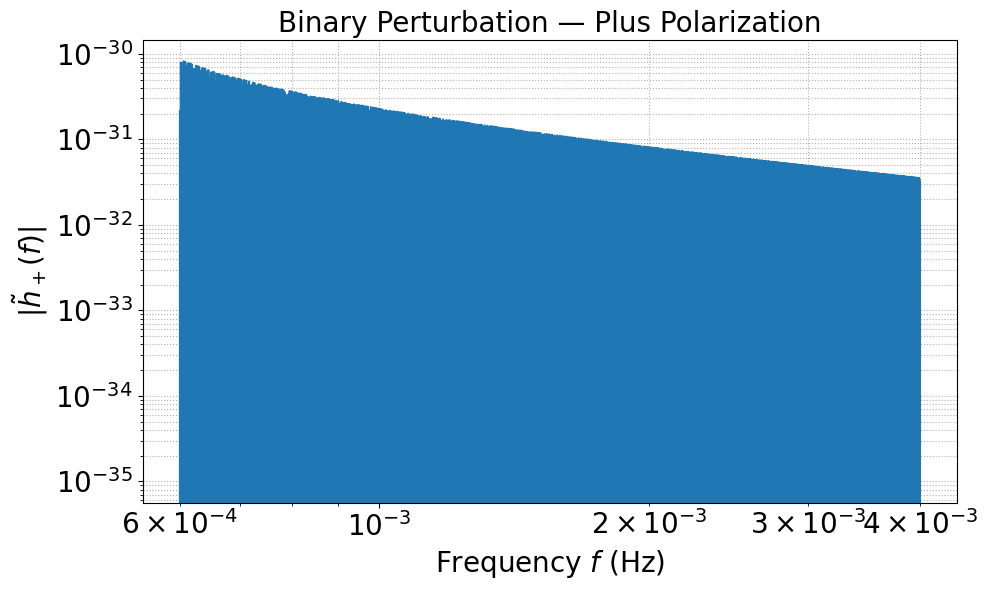

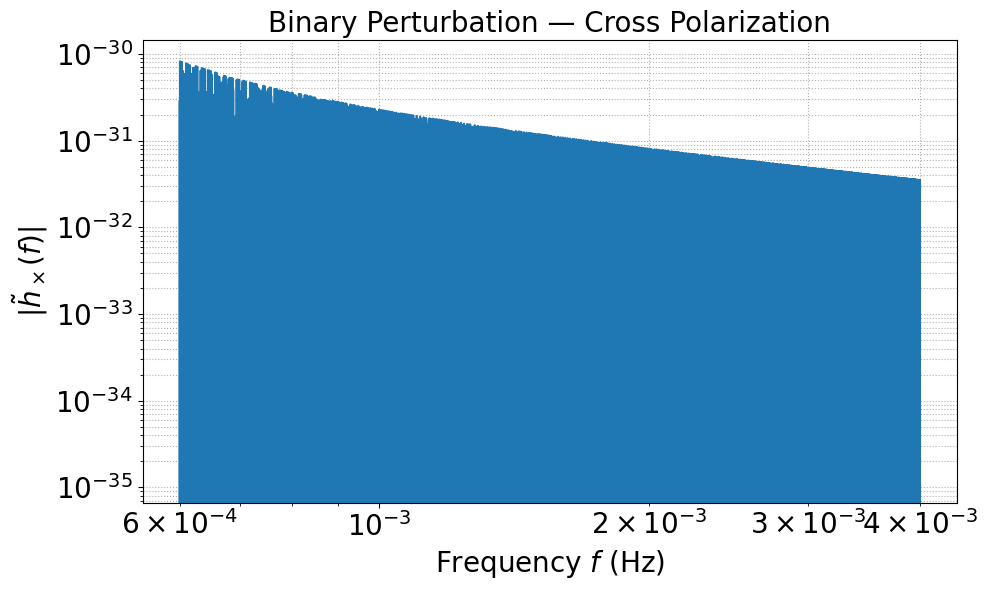

In [4]:

# Relevant Input parameters, units defined

Mp = 1.220890e19
G = 1 / Mp**2

M = 1e3      # BH mass in solar masses
r = 1    # kpc distance away
alpha  = 0.3
m_boson = alpha/(G*M) # Boson mass in GeV
q      = 0.1 # Binary mass ratio
m_i    = 1
m_f    = -1 # Quantum Numbers
eta    = 5.0e-2      # parameter entering z (or leave None to use z_scaling below)
# Frequency in Gev   # width |Γ| in Hz (or your freq units)

# Found for this freq range, can also be estimated using Omega0 function 
f = np.linspace(6e-4, 4e-3, 10000)

hplus_of_iota = htilde_plus(f, M, r, alpha, q, m_i, m_f, eta,use_z_scaling=False,relativistic = False  )

iota = np.pi  # rad
Hplus = hplus_of_iota(iota)
Hcross = hcross_from_hplus_freq(Hplus, iota)

# --- Plot h+ ---
plt.figure(figsize=(10,6))
plt.semilogy(f, Hplus)
plt.xlabel("Frequency $f$ (Hz)", fontsize=label_fs)
plt.ylabel(r"$|\tilde h_+(f)|$", fontsize=label_fs)
plt.title("Binary Perturbation — Plus Polarization", fontsize=title_fs)
plt.xscale('log')
plt.tick_params(axis='both', which='both', labelsize=tick_fs)
plt.grid(True, which='both', ls=":")
plt.tight_layout()
plt.show()

# --- Plot h× ---
plt.figure(figsize=(10,6))
plt.semilogy(f, Hcross)
plt.xlabel("Frequency $f$ (Hz)", fontsize=label_fs)
plt.ylabel(r"$|\tilde h_\times(f)|$", fontsize=label_fs)
plt.title("Binary Perturbation — Cross Polarization", fontsize=title_fs)
plt.xscale('log')
plt.tick_params(axis='both', which='both', labelsize=tick_fs)
plt.grid(True, which='both', ls=":")
plt.tight_layout()
plt.show()